In [2]:
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time

import statsmodels.formula.api as smf
from statsmodels.tools import add_constant as ac
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
import numpy as np
import rasterio.features as features
from affine import Affine
from shapely.geometry import shape
%matplotlib notebook

Array = np.zeros(shape = (10,10))


for shp, val in features.shapes(Array.astype(int), transform=Affine(1, 0, 0, 0, -1, 5)):
    print('%s: %s' % (val, shape(shp)))
    

0.0: POLYGON ((0 5, 0 -5, 10 -5, 10 5, 0 5))


In [4]:
def Daterize(df):
    df['HrMn'] = df['HrMn'].astype(str)
    df['Mn'] = df['HrMn'].str[-2:].astype(int)
    df['Hr'] = df['HrMn'].astype(int).floordiv(100).astype(str).str.replace('24','00')
    df.loc[df['Hr'] == '00',['DOY']]+=1
    df['Hr'] = df['Hr'].astype(int)
    df = df.set_index(pd.to_datetime(df['Year'] * 10000000 + df['DOY']*10000+df['Hr']*100+df['Mn'], format='%Y%j%H%M'))
    return(df)

def Deptherize(df,adj):
    df = pd.concat([df,adj],axis=1,join = 'inner')
    df.loc[df['Depth']<0,'Depth']=np.nan
#     plt.figure()
#     plt.plot(df['Depth'])
    df['Table'] = -.01*df['Probe'] + df['Depth']
    df.loc[((df.index>'2017-7-10 12:00:00')&((df.index<'2017-7-10 19:30:00'))),['Table']]=np.nan
    df.loc[((df.index>'2017-8-1 14:00:00')&((df.index<'2017-8-1 22:00:00'))),['Table']]=np.nan
    df['Table']=df['Table'].ffill()
    return(df)

def Droperize(df,drop):
    df = df.drop(drop, axis=1)
    return(df)

def Fluxerize(df,df2,key):
    Coef = [6.37192,6.27367,6.27367]
    df['HFP'] = df['HFP']*Coef[int(key)-1]
    Bulk_Density = 200 ## kg/m3 -- estimate
    Water_Density = 1000 ## kg/m3
    C_Dry = 840 ## j/kg/C
    C_Wet = 4184 ## j/kg/C
    df['Tdiff'] = df['Temp_2_5'].diff()
    df2.loc[df2['Period']<20,['Period']]=np.nan
    df2['Period'] = df2['Period']**.5
    df2['VWC'] = .5114*df2['Period']**3 -7.9851* df2['Period']**2 + 47.318*df2['Period'] -51.508
    df['cs'] = Bulk_Density *( C_Dry + C_Wet*Water_Density/Bulk_Density*df2['VWC']*.01)
    df['S'] = df['Tdiff']*df['cs']*.05/1800
    return(df,df2)

def Spike_Removalize(df,key):
    if key == '1':
        df.loc[df['VWC']<.17,'VWC']=np.nan
    if key == '2' or key == '3':
        df.loc[df['VWC']<.08,'VWC']=np.nan
    return(df)
def Resampleize(df):    
    df = df.resample('30T').asfreq().interpolate('linear')
    return(df)

def Processize(dr,file,key,ADJ):
    name = dr+'Water'+file
    Water = pd.read_csv(name)
    Water = Daterize(Water)
    if key == '1':
        Water.loc[Water.index<'2017-06-23 13:00:00','Depth']=np.nan
    Water = Deptherize(Water,ADJ)
    Water = Droperize(Water,['Year','DOY','HrMn','Hr','Mn','Date'])
    Water = Spike_Removalize(Water,key)
    Water = Resampleize(Water)
    
    Energy = pd.read_csv(dr+'Energy'+file)
    Energy = Daterize(Energy)
    Energy,Water = Fluxerize(Energy,Water,key)
    Energy = Droperize(Energy,['Year','DOY','HrMn','Hr','Mn','BattV','Sig','Itemp','BTemp_Max','MTemp_Max','TTemp_Max','HFP_Max','BTemp_Min','MTemp_Min','TTemp_Min','HFP_Min'])
    Energy.loc[Energy['HFP']<-100,'HFP']=np.nan
    Energy.loc[Energy.index<'2017-06-23 14:00:00','Temp_2.5']=np.nan
    
    Water = Water.add_suffix('_'+key)
    Energy = Energy.add_suffix('_'+key)
    return(Energy,Water)

<IPython.core.display.Javascript object>


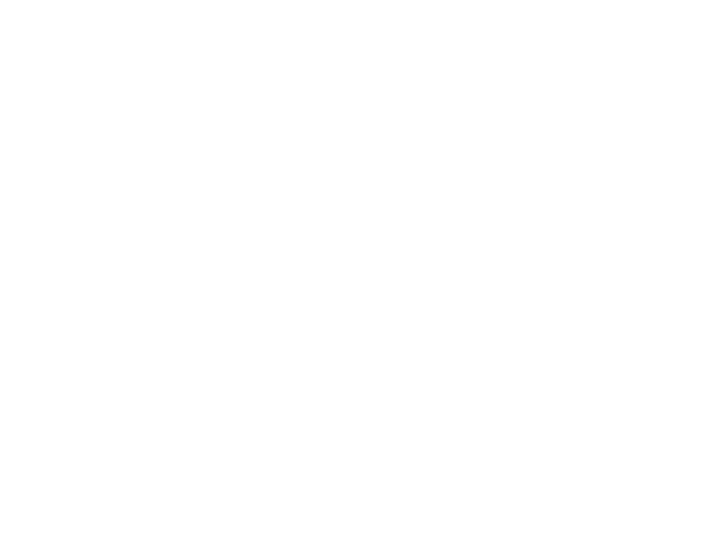

<IPython.core.display.Javascript object>


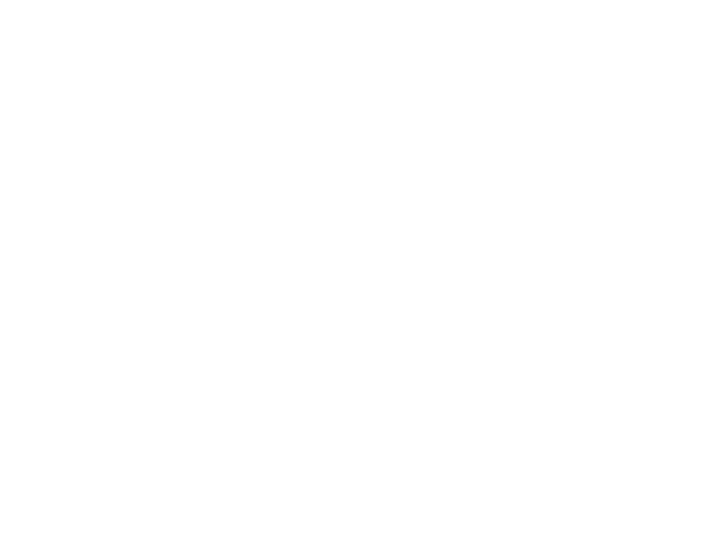

<IPython.core.display.Javascript object>


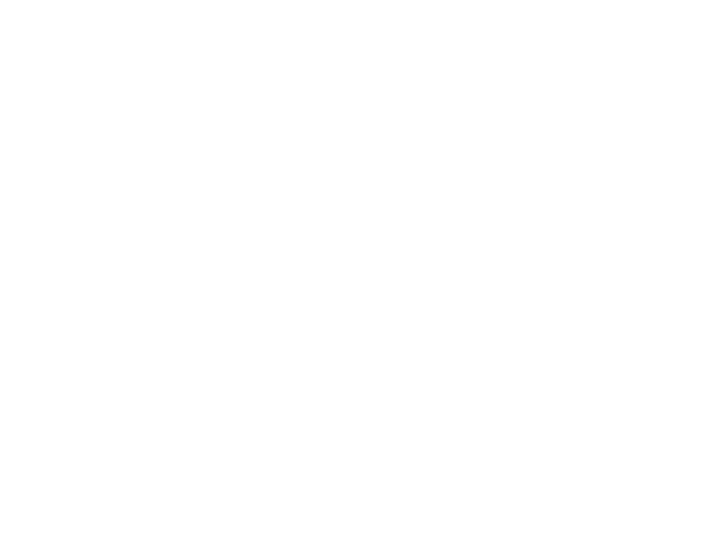

In [11]:
Conductivity_2 = np.asanyarray([0.2,0.39,0.5,0.8,1.15])
Conductivity_4 = np.asanyarray([0.18,0.35,0.5,0.7,0.9])
VWC = np.asanyarray([.2,.4,.6,.8,1])
d = {'2':Conductivity_2,'4':Conductivity_4,'VWC':VWC}
Cond = pd.DataFrame(data = d)

model2 = make_pipeline(PolynomialFeatures(2), Ridge(alpha = .1))
model4 = make_pipeline(PolynomialFeatures(2), Ridge(alpha = .1))
X = Cond['VWC'].values.reshape(-1, 1)
Y = Cond['2'].values
model2.fit(X,Y)
Y = Cond['4'].values
model4.fit(X,Y)

Dpath = 'C:\\FishIsland_2017\\SoilStationData/'
Whead = 'Year,DOY,HrMn,Depth,Temp,VWC,Period\n'
Ehead = 'Year,DOY,HrMn,BattV,Sig,Itemp,Temp_2_5,Temp_15,Temp_5,HFP,BTemp_Max,MTemp_Max,TTemp_Max,HFP_Max,BTemp_Min,MTemp_Min,TTemp_Min,HFP_Min\n'

def Adjerize(Probe,Date,CH,AL):
    d = {'Probe':Probe,'Date':Date}
    ADJ = pd.DataFrame(data = d)
    ADJ = ADJ.set_index(pd.DatetimeIndex(ADJ['Date']))
    ADJ = ADJ.resample('30T').ffill()
    d = {'Active_Layer':AL,'Canopy_Height':CH,'Date':Date}
    AL = pd.DataFrame(data = d)
    AL = AL.set_index(pd.DatetimeIndex(AL['Date']))
    AL = AL.drop('Date',axis = 1)
    AL = AL.resample('30T').asfreq().interpolate('linear')
    AL['Active_Layer'] = AL['Active_Layer']*.01
    ADJ = pd.concat([ADJ,AL],axis = 1, join = 'outer')
    return(ADJ)

Probe = np.asanyarray([21,26,31.2,31.2,31.2])
CH = np.asanyarray([8.1,8.3,11.3,14.0,14])
AL = np.asanyarray([21.75,29.5,35,43,52.5])
Date = np.asanyarray(['2017-6-22 00:00:00','2017-7-10 13:30:00','2017-8-1 15:00:00','2017-8-21 16:00:00','2017-9-13 15:00:00'])
ADJ1 = Adjerize(Probe,Date,CH,AL)
# print(ADJ1)

Probe = np.asanyarray([np.nan,25,31.3,31.3,31.3])
CH = np.asanyarray([13.3,15.5,17.4,23.0,23])
AL = np.asanyarray([19.5,28,34.5,42,50.5])
Date = np.asanyarray(['2017-6-22 00:00:00','2017-7-10 14:00:00','2017-8-1 15:00:00','2017-8-21 16:00:00','2017-9-13 15:00:00'])
ADJ2 = Adjerize(Probe,Date,CH,AL)

Probe = np.asanyarray([20,26.2,34.2,34.2,34.2])
CH = np.asanyarray([8.1,8.3,11.3,20.3,20.3])
AL = np.asanyarray([22.5,28.5,34.5,42.5,52.5])
Date = np.asanyarray(['2017-6-22 00:00:00','2017-7-10 14:30:00','2017-8-1 15:00:00','2017-8-21 16:00:00','2017-9-13 15:00:00'])
ADJ3 = Adjerize(Probe,Date,CH,AL)

List = []
for dr, sub, files in os.walk(Dpath):
    for file in files:
        if file[0:3] == 'Sat':
            D = open(dr+file)
            Data = D.readlines()
            D.close()
            energy = open(dr+'Processed/Energy'+file,'w')
            water = open(dr+'Processed/Water'+file,'w')
            energy.write(Ehead)
            water.write(Whead)
                
            for line in Data:
                if line[0:3] == '101':
                    water.write(line[4:])
                else:
                    energy.write(line[4:])
            water.close()
            energy.close()
            
            if file == 'Sat3_Data.dat':
                D = open(dr+'Processed/Water'+file)
                Data = D.readlines()
                D.close()
E1,W1 = Processize('C:\\FishIsland_2017\\SoilStationData/Processed/','Sat1_Data.DAT','1',ADJ1)
E2,W2 = Processize('C:\\FishIsland_2017\\SoilStationData/Processed/','Sat2_Data.DAT','2',ADJ2)
E3,W3 = Processize('C:\\FishIsland_2017\\SoilStationData/Processed/','Sat3_Data.DAT','3',ADJ3)

E = pd.concat([E1,E2,E3],axis = 1, join = 'outer')
W = pd.concat([W1,W2,W3],axis = 1, join = 'outer')
Master = pd.concat([E,W],axis =1, join = 'outer')


Profile1 = (Master['Temp_5_1']-Master['Temp_2_5_1'])/.025 
Profile2 = (Master['Temp_15_1']-Master['Temp_5_1'])/.1
Profile3 = (Master['Temp_15_1']-Master['Temp_2_5_1'])/.125
Profile = (Profile1 + Profile2 + Profile3)/3

X = Master['VWC_1'].bfill().ffill().values.reshape(-1, 1)*.01
Cond = model4.predict(X)
     
X2 = Master['VWC_2'].bfill().ffill().values.reshape(-1, 1)*.01
Cond2 = model4.predict(X2)
Master['HFX'] = -(Cond*.8+Cond2*.2)*(Master['Temp_15_1']-Master['Temp_2_5_1'])/.125
Master['HFX'] = Master['HFX']+ (Master['S_1']*.8+Master['S_2']*.2)
Master['Zo'] = ((Master['Canopy_Height_1']*.8+Master['Canopy_Height_2']*.2)*.01).bfill()

Master.to_csv(Dpath+'Soil_Data.csv')


In [10]:
print(Master['Zo'].bfill())
# Master['Zo'] = (Master['Canopy_Height_1']*.8+Master['Canopy_Height_2']*.2)*.01
# print(Master['Zo'])

2017-06-22 13:00:00    0.091858
2017-06-22 13:30:00    0.091858
2017-06-22 14:00:00    0.091858
2017-06-22 14:30:00    0.091858
2017-06-22 15:00:00    0.091858
                         ...   
2017-09-13 10:00:00    0.158000
2017-09-13 10:30:00    0.158000
2017-09-13 11:00:00    0.158000
2017-09-13 11:30:00    0.158000
2017-09-13 12:00:00    0.158000
Freq: 30T, Name: Zo, Length: 3983, dtype: float64


         VWC_1      VWC_2
DOY                      
212  48.847511  46.861798
         VWC_1      VWC_2
DOY                      
232  49.117901  47.075695


<IPython.core.display.Javascript object>


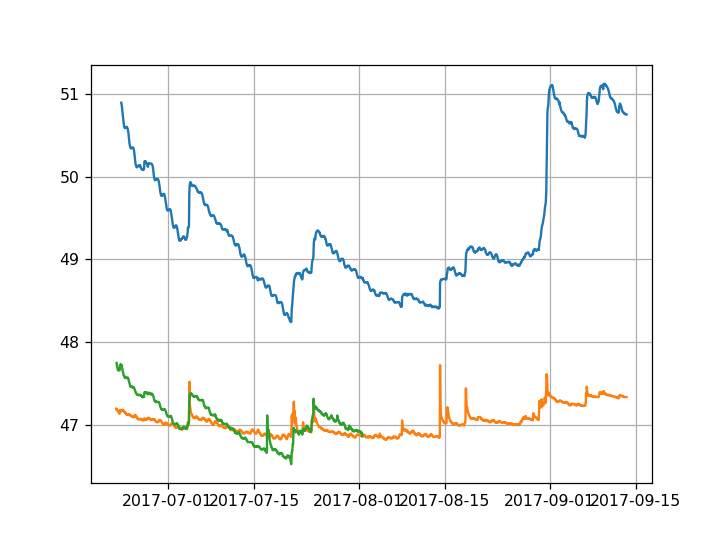

<IPython.core.display.Javascript object>


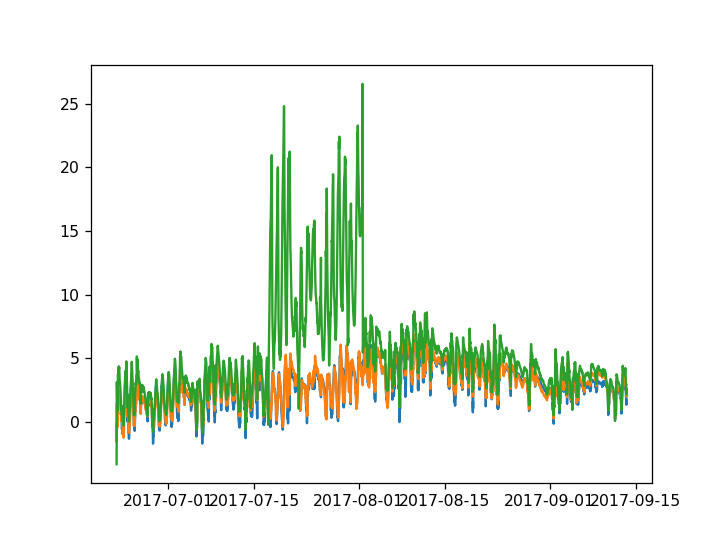

<IPython.core.display.Javascript object>


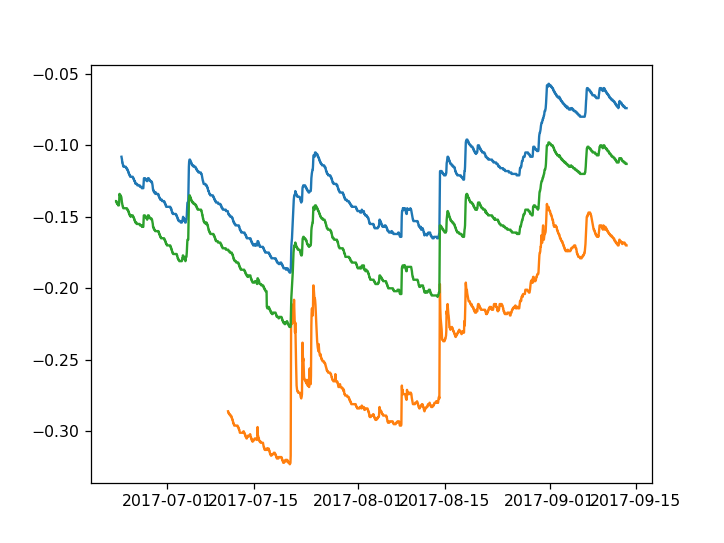

In [10]:
# %matplotlib inline
Master['DOY'] = Master.index.dayofyear
Master['Month'] = Master.index.month
Master['Day'] = Master.index.day
Daily = Master.groupby(['DOY']).mean()

print(Daily.loc[((Daily['Day']==31)&(Daily['Month']==7)),['VWC_1','VWC_2']])
print(Daily.loc[((Daily['Day']==20)&(Daily['Month']==8)),['VWC_1','VWC_2']])

plt.figure()
plt.plot(Master['VWC_1'])
plt.plot(Master['VWC_2'])
plt.plot(Master['VWC_3'])
# plt.plot([212,212],[46,50])
# plt.plot([232,232],[46,50])
# plt.xlim(210,235)
plt.grid()

plt.figure()
plt.plot(Master['Temp_15_1'])
plt.plot(Master['Temp_15_2'])
plt.plot(Master['Temp_15_3'])

## DOY 213 Validations
## VWC_1 = .428, VWC_2 = .313
## DOY 233 Validations
## VWC_1 = .444, VWC_2 = .266
plt.figure()
plt.plot(Master['Table_1'])
plt.plot(Master['Table_2'])
plt.plot(Master['Table_3'])

<IPython.core.display.Javascript object>


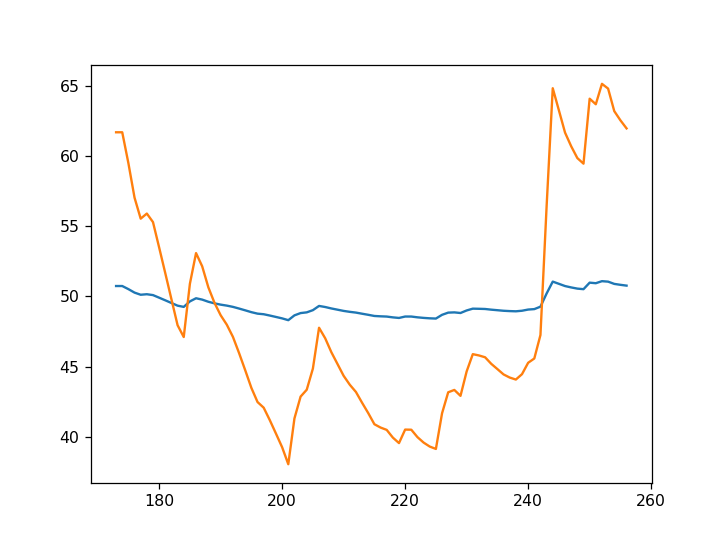

In [6]:
VWC_1 = np.asanyarray([42.8,44.4])
VWC_1 = np.asanyarray([43.2,45.8])
# VWC_1 = np.asanyarray([31.3,26.6])
# Conductivity_4 = np.asanyarray([0.18,0.35,0.5,0.7,0.9])
VWC = np.asanyarray([48.847511,49.11790])
# VWC = np.asanyarray([46.861798,47.075695])
d = {'1':VWC_1,'VWC':VWC}
Cond = pd.DataFrame(data = d)

model2 = make_pipeline(PolynomialFeatures(2), Ridge(alpha = .1))
# model4 = make_pipeline(PolynomialFeatures(2), Ridge(alpha = .1))
X = Cond['VWC'].values.reshape(-1, 1)
Y = Cond['1'].values
model2.fit(X,Y)
Daily['VWC_1'] = Daily['VWC_1'].fillna(method = 'ffill').fillna(method='bfill')
X2 = Daily['VWC_1'].values.reshape(-1, 1)
# print(X2)
Fix = model2.predict(X2)
plt.figure()
Daily['VWC_Fill'] = Daily['VWC_1']*0+Fix
plt.plot(Daily['VWC_1'])
plt.plot(Daily['VWC_Fill'])
# Y = Cond['4'].values
# model4.fit(X,Y)


In [7]:
A1=np.array([23, 21.5, 23.5, 23, 21.5, 23, 22, 22, 22.5, 23.5])
A2=np.array([24.5, 25, 28.5, 25, 26, 27, 22, 23.5, 26.5, 22.5])
A3=np.array([24.5, 24.5, 19, 23, 23.5, 20, 21, 22.5, 21.5, 20.5])
for a in [A1,A2,A3]:
    print(np.median(a)-44.5)
#     print(np.mean(a)-44.5)

A1=np.array([28, 28, 28, 32, 30, 30, 30, 32, 28, 29])
A2=np.array([22, 24, 30, 30, 26, 28, 28, 32, 29, 28])
A3=np.array([28, 32, 27, 29, 28, 28, 28, 29, 31, 32])

for a in [A1,A2,A3]:
    print(np.median(a))
    
A1=np.array([34, 33, 36, 37, 36, 35, 34, 34, 36, 35])
A2=np.array([33, 29, 34, 36, 31, 35, 36, 39, 31, 37])
A3=np.array([33, 39, 30, 33, 34, 35, 35, 35, 34, 36])

for a in [A1,A2,A3]:
    print(np.median(a))
    
    
A1=np.array([40, 40, 41, 42, 43, 46, 44, 48, 43, 44])
A2=np.array([43, 40, 49, 41, 43, 45, 36, 41, 38, 45])
A3=np.array([40, 39, 43, 43, 43, 40, 37, 43, 49, 42])

for a in [A1,A2,A3]:
    print(np.median(a))

    
A1=np.array([53, 51, 54, 52, 54, 54, 53, 49, 47, 46])
A2=np.array([53, 48, 52, 49, 44, 58, 43, 55, 46, 58])
# A3=np.array([40, 39, 43, 43, 43, 40, 37, 43, 49, 42])

for a in [A1,A2]:
    print(np.median(a))

-21.75
-19.5
-22.5
29.5
28.0
28.5
35.0
34.5
34.5
43.0
42.0
42.5
52.5
50.5


<IPython.core.display.Javascript object>


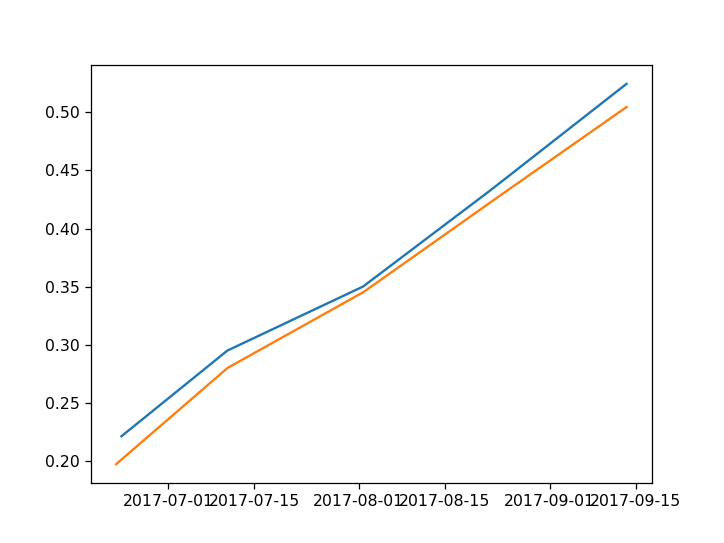

In [8]:
plt.figure()
plt.plot(Master['Active_Layer_1'])
plt.plot(Master['Active_Layer_2'])